# Problem Set 4: Model Building Part 1 
Team 5: Eva Rickard, Alyssa Nguyen, Audrey Kimball


## Project Questions
Our big picture question:  
“How do social and demographic factors relate to neighborhood-level health outcomes in Seattle?”

Sub-questions:  
"What are the primary dimensions that explain variation in social and health disadvantage across Seattle neighborhoods?"  
"What underlying factors best represent the social and health conditions of Seattle neighborhoods?"  
"How can Seattle neighborhoods be grouped based on shared patterns of social and health disadvantage?"  

Our project examines how social and demographic factors relate to neighborhood-level health outcomes in Seattle. Specifically, we aim to understand how patterns of socioeconomic disadvantage, health burden, and access disparities interact across different communities. To address this overarching question, we apply three complementary analytical methods. First, we use Principal Component Analysis (PCA) to identify the primary dimensions that explain variation in social and health disadvantage among Seattle neighborhoods. Next, we employ Factor Analysis to uncover the underlying latent constructs that best represent the shared conditions influencing neighborhood well-being. Finally, we use K-Means Clustering to group neighborhoods based on their social and health characteristics, allowing us to distinguish clusters of communities that face similar types or levels of disadvantage. Together, these models help reveal the structure, relationships, and patterns that shape health inequities across Seattle.


## PCA Model

In [137]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

#Read in csv 
df = pd.read_csv(r"C:/Users/alyss/OneDrive - Washington State University (email.wsu.edu)\Data 422\final_analysis_data.csv")


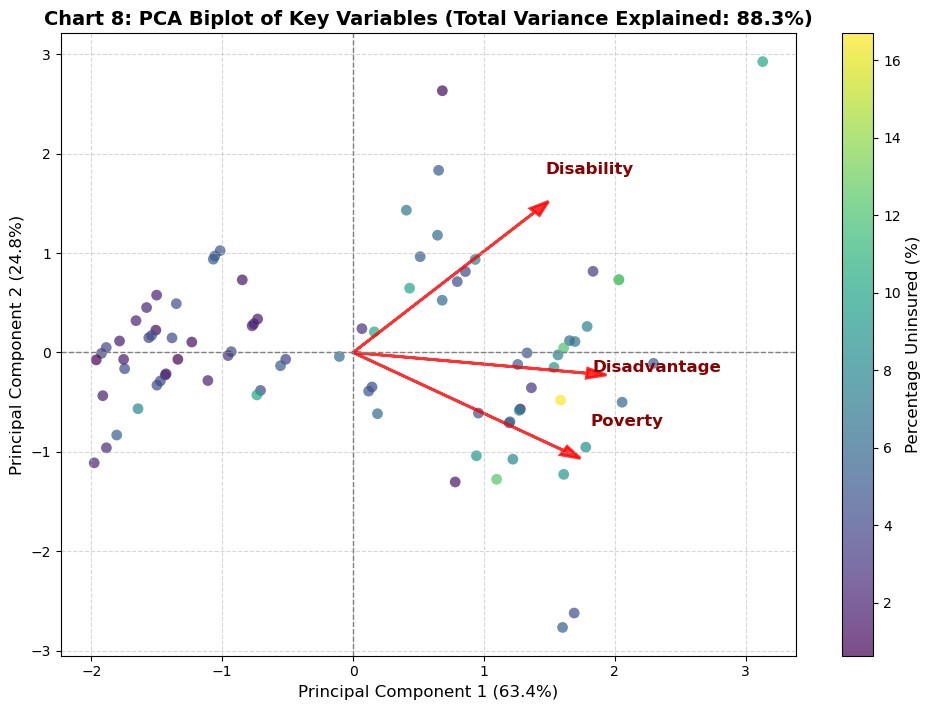

In [26]:
features = ['health_disadvantage_score_AVG', 'poverty_rate_avg', 'percent_adults_with_disability']
X = df[features].dropna().values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['percent_uninsured'] = df['percent_uninsured'].loc[df[features].dropna().index].values

plt.figure(figsize=(10, 8))

# Scatter plot colored by Uninsured Rate
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['percent_uninsured'],
    cmap='viridis',
    s=60, alpha=0.7, edgecolors='none'
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Percentage Uninsured (%)', fontsize=12)

# Plot the loadings (vectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Clean, readable labels
labels = ['Disadvantage', 'Poverty', 'Disability']

# Scale arrows dynamically for visibility
arrow_scale = 2.0
text_offset = 0.30

for i, feature in enumerate(features):
    x_arrow = loadings[i, 0] * arrow_scale
    y_arrow = loadings[i, 1] * arrow_scale
    plt.arrow(0, 0, x_arrow, y_arrow,
              color='red', alpha=0.8,
              head_width=0.1, head_length=0.15, linewidth=2)
    
    # Offset label slightly beyond arrow tip for readability
    plt.text(
        x_arrow * (1 + text_offset * np.sign(x_arrow)),
        y_arrow * (1 + text_offset * np.sign(y_arrow)),
        labels[i],
        color='darkred', fontsize=12, fontweight='bold', ha='center', va='center'
    )

# Titles and axis labels
explained_variance = pca.explained_variance_ratio_.sum() * 100
plt.title(f'Chart 8: PCA Biplot of Key Variables (Total Variance Explained: {explained_variance:.1f}%)',
          fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

## PCA Biplot Summary

To explore how social and demographic factors interact and jointly shape neighborhood health outcomes, a Principal Component Analysis (PCA) was conducted on three key indicators: health disadvantage, poverty rate, and percent of adults with disabilities. These variables were selected because they represent overlapping dimensions of socioeconomic vulnerability and community well-being.

The first two principal components explained 88.3% of the total variance, indicating that most of the variation in these factors can be summarized in two main dimensions.

Principal Component 1 (63.4%) was primarily driven by poverty and health disadvantage, forming a clear axis of socioeconomic hardship.

Principal Component 2 (24.8%) was dominated by disability rates, reflecting an additional but less pronounced health limitation dimension.

When neighborhoods were plotted according to their PCA scores, a visible gradient appeared: areas with higher poverty and disadvantage (toward the right of the plot) tended to have higher percentages of uninsured residents, shown in yellow tones. This pattern statistically supports that socioeconomic disadvantage is closely linked to poorer access to healthcare at the neighborhood level.

Overall, the PCA biplot helps visualize the underlying structure among social factors, showing that poverty and overall disadvantage cluster together and strongly align with negative health outcomes (higher uninsured rates). Disability contributes a secondary, orthogonal dimension of health vulnerability.

These findings suggest that in Seattle, economic and structural disadvantage are the dominant social determinants of neighborhood health, while disability adds further variation that might reflect distinct barriers to care or accessibility.

## Factor Analysis Model

In [141]:
#Importing libraries for Factor analysis
import seaborn as sns
from pylab import rcParams
import string
import re
import math
from matplotlib import rc
#from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

!pip install factor_analyzer

In [150]:
#read in files
df2 = pd.read_csv(r"C:\Users\alyss\OneDrive - Washington State University (email.wsu.edu)\Data 422\disability_composite_joined.csv") # big data for more exploration

#strip whitespace from column names (optional but I like to err on the side of caution)
df2.columns = df2.columns.str.strip()

# drop columns that contain any 0
cols_to_drop = [col for col in df2.columns if (df2[col] == 0).any()]
df2.drop(columns=cols_to_drop, inplace=True)

#cutting down the larger data to something smaller for FA
df2.head() #drop columns that have strings
df2.drop(['neighborhood_type','neighborhood_subtype','acs_vinatage','neighborhood_type_(outside_comp_plan_areas_id)','l_hood_mapped','l_hood'],axis=1,inplace=True)

# columns selected for factor analysis, ones I think will give us the most info
cols_for_factor = [
    'pct_people_of_color_mean',
    'pct_english_lang_learners_mean',
    'pct_foreign_born_mean',
    'pct_pop_under200pct_poverty_mean',
    'pct_less_bachelor_degree_mean',
    'pct_adult_noleisurephysactiv_mean',
    'pct_adult_with_diabetes_mean',
    'pct_adult_with_obesity_mean',
    'pct_adult_mentalhlthnotgood_mean',
    'pct_adult_with_asthma_mean',
    'life_expectancy_at_birth_mean',
    'pct_adult_with_disability_mean',
    'composite_percentile_mean',
    'socioecon_disadv_percentile_mean',
    'health_disadv_percentile_mean',
    'pop_total_for_foreign_born_mean',
    'pop_english_lang_learners_mean',
    'pop_under200pct_poverty_mean',
    'pop_less_than_bachelor_deg_mean',
    'pop_adult_with_disability_mean'
]

# Create a new DataFrame with just these columns
df_factor = df2[cols_for_factor]

We selected 20 variables from the dataset that I thought would be interesting to look at 

I then did some cleaning and stripping of whitespace. Then I removed columns that had more than 95% correlation. The analysis wouldn’t let me proceed past this without removing these because, as I found out, the high correlation causes the correlation matrix to become nearly singular. All in all what it boiled down to was tht FA cant tell whether those two (or more variables) that are so highly correlate are one underlying concept or two identical copies.

I then ran Bartless test to see if there was even value in factor analysis at all, requires that the data from each group be normally distributed. The main goal of the bartlett test is to test of the correlation matrix of the dataset is an identity matrix (ie. uncorrelated)..

In [152]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# drop constant columns
df_factor = df_factor.loc[:, df_factor.nunique() > 1]

#missing values
df_factor = df_factor.dropna()

#perfectly correlated columns, not doing this gave me issues with the FA,
#too perfectly correlated makes the FA wack out due to colinearity
corr_matrix = df_factor.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] >= 0.95)]
df_factor = df_factor.drop(columns=to_drop)

print(f"Columns kept after removing high correlations ({len(df_factor.columns)}):")
print(df_factor.columns.tolist())

# Run Bartlett’s test to see if there is even value in a factor analysis at all.
chi_square_value, p_value = calculate_bartlett_sphericity(df_factor)
print("\nBartlett’s Test Results:")
print(f"Chi-square value: {chi_square_value}")
print(f"P-value: {p_value}")

Columns kept after removing high correlations (15):
['pct_people_of_color_mean', 'pct_english_lang_learners_mean', 'pct_foreign_born_mean', 'pct_pop_under200pct_poverty_mean', 'pct_less_bachelor_degree_mean', 'pct_adult_with_diabetes_mean', 'pct_adult_with_obesity_mean', 'pct_adult_mentalhlthnotgood_mean', 'pct_adult_with_asthma_mean', 'life_expectancy_at_birth_mean', 'pct_adult_with_disability_mean', 'composite_percentile_mean', 'pop_total_for_foreign_born_mean', 'pop_under200pct_poverty_mean', 'pop_adult_with_disability_mean']

Bartlett’s Test Results:
Chi-square value: 3047.9207917653334
P-value: 0.0


A strong chi-square value means big deviation from the null hypothesis. In this case, the null hypothesis is that the correlation matrix is an identity matrix, so a strong chi square value means that the variables are correlated to some degree with each other.

The low p value indicates significance

In [154]:
# adequacy test, bartlett test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(461.62528647313127, 1.4932831135023243e-84)

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion is more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

Are the correlations strong and consistent enough to form factors? Basically looking at the other side of the Bartlett coin.

Sources:  
https://www.analyticsvidhya.com/blog/2020/10/dimensionality-reduction-using-factor-analysis-in-python/  




https://www.youtube.com/watch?v=ttBs_wfw_6U

In [156]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model2=calculate_kmo(df_factor)


C:\Users\alyss\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [158]:
kmo_model

0.7119241108977561

In [164]:
kmo_model2

0.6359715937186525

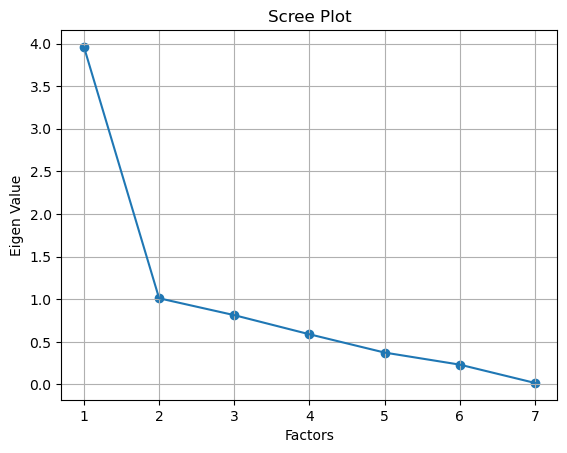

In [166]:
from factor_analyzer import FactorAnalyzer

# Create the factor analyzer object with specified parameters
fa = FactorAnalyzer(rotation=None, impute="drop", n_factors=df.shape[1])

# Fit the factor analyzer to the dataframe
fa.fit(df)

# Get eigenvalues, amount of variance a factor explains 
ev, _ = fa.get_eigenvalues()

# Create scree plot, see if 6 factors is enough 
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

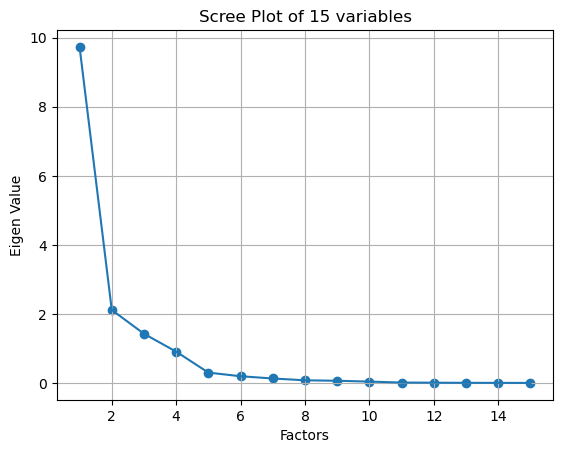

In [168]:
from factor_analyzer import FactorAnalyzer

# Create the factor analyzer object with specified parameters
fa = FactorAnalyzer(rotation=None, impute="drop", n_factors=df.shape[1])

# Fit the factor analyzer to the dataframe
fa.fit(df_factor)

# Get eigenvalues, amount of variance a factor explains 
ev, _ = fa.get_eigenvalues()

# Create scree plot, see 15 factors 
plt.scatter(range(1, df_factor.shape[1]+1), ev)
plt.plot(range(1, df_factor.shape[1]+1), ev)
plt.title('Scree Plot of 15 variables')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

Due to the elbow being around the 5th factor mark, that is what I used for the rest of the analysis. 

In [170]:
my_matrix = df.corr(method="spearman").round(2)
my_matrix.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,percent_uninsured,percent_adults_with_disability,health_disadvantage_score_AVG,composite_score_AVG,poverty_rate_avg,population_count,disability_rate_mean_of_ratios_AVG
percent_uninsured,1.000000,0.430000,0.560000,0.590000,0.570000,-0.170000,0.500000
percent_adults_with_disability,0.430000,1.000000,0.540000,0.530000,0.410000,-0.100000,0.630000
health_disadvantage_score_AVG,0.560000,0.540000,1.000000,0.940000,0.750000,-0.220000,0.810000
composite_score_AVG,0.590000,0.530000,0.940000,1.000000,0.820000,-0.190000,0.800000
poverty_rate_avg,0.570000,0.410000,0.750000,0.820000,1.000000,-0.100000,0.640000
population_count,-0.170000,-0.100000,-0.220000,-0.190000,-0.100000,1.000000,-0.230000
disability_rate_mean_of_ratios_AVG,0.500000,0.630000,0.810000,0.800000,0.640000,-0.230000,1.000000


In [172]:
my_matrix = df_factor.corr(method="spearman").round(2)
my_matrix.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)
#do this method for final proj but looking at pct people of color, english language native, and local born in comparison for mental health and such. 

,pct_people_of_color_mean,pct_english_lang_learners_mean,pct_foreign_born_mean,pct_pop_under200pct_poverty_mean,pct_less_bachelor_degree_mean,pct_adult_with_diabetes_mean,pct_adult_with_obesity_mean,pct_adult_mentalhlthnotgood_mean,pct_adult_with_asthma_mean,life_expectancy_at_birth_mean,pct_adult_with_disability_mean,composite_percentile_mean,pop_total_for_foreign_born_mean,pop_under200pct_poverty_mean,pop_adult_with_disability_mean
pct_people_of_color_mean,1.000000,0.920000,0.940000,0.860000,0.770000,0.750000,0.620000,0.720000,0.550000,-0.680000,0.700000,0.910000,0.210000,0.840000,0.700000
pct_english_lang_learners_mean,0.920000,1.000000,0.820000,0.870000,0.900000,0.820000,0.720000,0.760000,0.700000,-0.810000,0.770000,0.960000,0.320000,0.890000,0.770000
pct_foreign_born_mean,0.940000,0.820000,1.000000,0.770000,0.680000,0.620000,0.480000,0.690000,0.370000,-0.570000,0.580000,0.820000,0.120000,0.730000,0.600000
pct_pop_under200pct_poverty_mean,0.860000,0.870000,0.770000,1.000000,0.720000,0.650000,0.540000,0.820000,0.590000,-0.650000,0.640000,0.820000,0.110000,0.900000,0.630000
pct_less_bachelor_degree_mean,0.770000,0.900000,0.680000,0.720000,1.000000,0.850000,0.800000,0.740000,0.710000,-0.830000,0.830000,0.950000,0.410000,0.820000,0.830000
pct_adult_with_diabetes_mean,0.750000,0.820000,0.620000,0.650000,0.850000,1.000000,0.910000,0.430000,0.550000,-0.790000,0.780000,0.860000,0.470000,0.770000,0.830000
pct_adult_with_obesity_mean,0.620000,0.720000,0.480000,0.540000,0.800000,0.910000,1.000000,0.460000,0.680000,-0.850000,0.730000,0.780000,0.650000,0.750000,0.820000
pct_adult_mentalhlthnotgood_mean,0.720000,0.760000,0.690000,0.820000,0.740000,0.430000,0.460000,1.000000,0.670000,-0.640000,0.610000,0.770000,0.160000,0.780000,0.580000
pct_adult_with_asthma_mean,0.550000,0.700000,0.370000,0.590000,0.710000,0.550000,0.680000,0.670000,1.000000,-0.700000,0.480000,0.730000,0.510000,0.690000,0.480000
life_expectancy_at_birth_mean,-0.680000,-0.810000,-0.570000,-0.650000,-0.830000,-0.790000,-0.850000,-0.640000,-0.700000,1.000000,-0.780000,-0.830000,-0.450000,-0.800000,-0.810000


Correlation matrix for the 15 variables shows some very interesting points. More than I am really able to discuss but here's some highlights:

-Pct adults with mental health being not good and pct with less than a college degree | .74

Perhaps communities with lower education tend to report higher rates of poor mental health? Chronic stress and reduced access to mental health services?

-pct of people of color and pct adults with diabetes | .75

Perhaps due to structural inequalities? More surrounded by food options that are fast food or ready made options that tend to be higher in trans fats and sodium. Decreased access to healthy food, healthcare, areas for exercise etc.

-pct mental health not good and pct English language learners | .76

Possible barriers include social isolation, limited access to culturally appropriate mental health care, and language barriers.

-pop under 200 pct poverty mean and pct English language learners | .89

Areas where economic opportunity are limited, especially for higher income jobs or sectors with large job mobility.

-pct of adult with obesity and pct with less than a college degree | .80

Education is a protective factor for physical health. This could mean that those with lower education are more at risk for obesity and other chronic conditions.

In [174]:
my_matrix = df.corr(method="spearman").round(2)
my_matrix.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,percent_uninsured,percent_adults_with_disability,health_disadvantage_score_AVG,composite_score_AVG,poverty_rate_avg,population_count,disability_rate_mean_of_ratios_AVG
percent_uninsured,1.000000,0.430000,0.560000,0.590000,0.570000,-0.170000,0.500000
percent_adults_with_disability,0.430000,1.000000,0.540000,0.530000,0.410000,-0.100000,0.630000
health_disadvantage_score_AVG,0.560000,0.540000,1.000000,0.940000,0.750000,-0.220000,0.810000
composite_score_AVG,0.590000,0.530000,0.940000,1.000000,0.820000,-0.190000,0.800000
poverty_rate_avg,0.570000,0.410000,0.750000,0.820000,1.000000,-0.100000,0.640000
population_count,-0.170000,-0.100000,-0.220000,-0.190000,-0.100000,1.000000,-0.230000
disability_rate_mean_of_ratios_AVG,0.500000,0.630000,0.810000,0.800000,0.640000,-0.230000,1.000000


Shows correlation between each variable and each extracted factor

In [176]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
# Run factor analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df)

# Display factor loadings
print(pd.DataFrame(fa.loadings_, index=df.columns))

                                           0         1
percent_uninsured                   0.553928  0.234024
percent_adults_with_disability      0.228229  0.971447
health_disadvantage_score_AVG       0.899670  0.275080
composite_score_AVG                 0.986815  0.232255
poverty_rate_avg                    0.689742  0.108628
population_count                   -0.195326 -0.082827
disability_rate_mean_of_ratios_AVG  0.661610  0.453414


In [178]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
# Run factor analysis
fa2 = FactorAnalyzer(n_factors=5, rotation='varimax')
fa2.fit(df_factor)

# Display factor loadings
print(pd.DataFrame(fa2.loadings_, index=df_factor.columns))

                                         0         1         2         3  \
pct_people_of_color_mean          0.881712  0.338430  0.247027  0.070942   
pct_english_lang_learners_mean    0.909159  0.315698  0.172591  0.135209   
pct_foreign_born_mean             0.882357  0.284569  0.159999 -0.144398   
pct_pop_under200pct_poverty_mean  0.595723  0.204311  0.706890 -0.145187   
pct_less_bachelor_degree_mean     0.631795  0.588308  0.293161  0.282833   
pct_adult_with_diabetes_mean      0.795041  0.472091 -0.001027  0.289405   
pct_adult_with_obesity_mean       0.346930  0.723303  0.193458  0.462362   
pct_adult_mentalhlthnotgood_mean  0.162466  0.075958  0.973633 -0.116249   
pct_adult_with_asthma_mean        0.098729  0.136618  0.909394  0.142911   
life_expectancy_at_birth_mean    -0.307479 -0.721051 -0.289792 -0.247371   
pct_adult_with_disability_mean    0.383153  0.891137  0.037418 -0.186698   
composite_percentile_mean         0.634011  0.625488  0.414736  0.126919   
pop_total_fo

In [180]:
# Get variance of each factors
fa.get_factor_variance()

(array([3.0937595 , 1.35233191]),
 array([0.44196564, 0.19319027]),
 array([0.44196564, 0.63515592]))

In [182]:
fa2.get_factor_variance()

(array([5.20207414, 4.07589334, 3.03104589, 1.50752952, 0.29356359]),
 array([0.34680494, 0.27172622, 0.20206973, 0.10050197, 0.01957091]),
 array([0.34680494, 0.61853117, 0.82060089, 0.92110286, 0.94067377]))

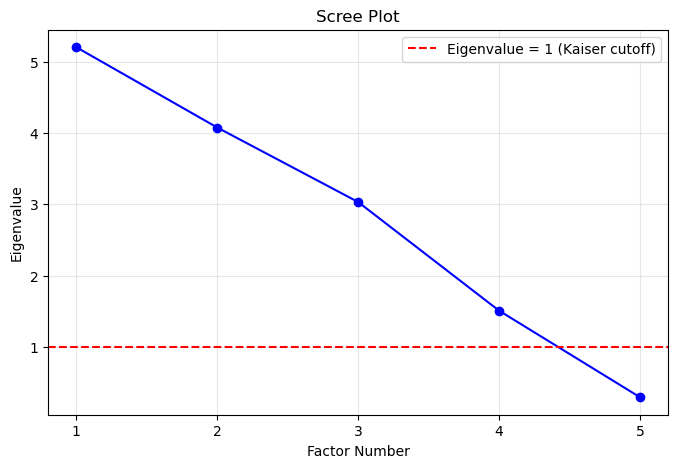

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Get variance (eigenvalues) from your fitted factor analyzer
eigenvalues, proportion_variance, cumulative_variance = fa2.get_factor_variance()

# Make the scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='blue')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='red', linestyle='--', label='Eigenvalue = 1 (Kaiser cutoff)')
plt.xticks(np.arange(1, len(eigenvalues) + 1))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [186]:
# Factor loadings
loadings = fa2.loadings_
loadings_df = pd.DataFrame(loadings, index=df_factor.columns, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])])
print(loadings_df)

# Assign each variable to the factor with the highest absolute loading
variable_to_factor = loadings_df.abs().idxmax(axis=1)
print(variable_to_factor)
# Only keep loadings > 0.4

                                  Factor 1  Factor 2  Factor 3  Factor 4  \
pct_people_of_color_mean          0.881712  0.338430  0.247027  0.070942   
pct_english_lang_learners_mean    0.909159  0.315698  0.172591  0.135209   
pct_foreign_born_mean             0.882357  0.284569  0.159999 -0.144398   
pct_pop_under200pct_poverty_mean  0.595723  0.204311  0.706890 -0.145187   
pct_less_bachelor_degree_mean     0.631795  0.588308  0.293161  0.282833   
pct_adult_with_diabetes_mean      0.795041  0.472091 -0.001027  0.289405   
pct_adult_with_obesity_mean       0.346930  0.723303  0.193458  0.462362   
pct_adult_mentalhlthnotgood_mean  0.162466  0.075958  0.973633 -0.116249   
pct_adult_with_asthma_mean        0.098729  0.136618  0.909394  0.142911   
life_expectancy_at_birth_mean    -0.307479 -0.721051 -0.289792 -0.247371   
pct_adult_with_disability_mean    0.383153  0.891137  0.037418 -0.186698   
composite_percentile_mean         0.634011  0.625488  0.414736  0.126919   
pop_total_fo

In [188]:
strong_loadings = loadings_df[loadings_df.abs() > 0.4].dropna(how='all')
print(strong_loadings)

                                  Factor 1  Factor 2  Factor 3  Factor 4  \
pct_people_of_color_mean          0.881712       NaN       NaN       NaN   
pct_english_lang_learners_mean    0.909159       NaN       NaN       NaN   
pct_foreign_born_mean             0.882357       NaN       NaN       NaN   
pct_pop_under200pct_poverty_mean  0.595723       NaN  0.706890       NaN   
pct_less_bachelor_degree_mean     0.631795  0.588308       NaN       NaN   
pct_adult_with_diabetes_mean      0.795041  0.472091       NaN       NaN   
pct_adult_with_obesity_mean            NaN  0.723303       NaN  0.462362   
pct_adult_mentalhlthnotgood_mean       NaN       NaN  0.973633       NaN   
pct_adult_with_asthma_mean             NaN       NaN  0.909394       NaN   
life_expectancy_at_birth_mean          NaN -0.721051       NaN       NaN   
pct_adult_with_disability_mean         NaN  0.891137       NaN       NaN   
composite_percentile_mean         0.634011  0.625488  0.414736       NaN   
pop_total_fo

In [190]:
factor_groups = {}

for factor in loadings_df.columns:  # Factor 1, Factor 2, ...
    # Select variables whose highest absolute loading is on this factor
    vars_in_factor = variable_to_factor[variable_to_factor == factor].index.tolist()
    factor_groups[factor] = vars_in_factor

# Print grouped variables
for factor, variables in factor_groups.items():
    print(f"\n{factor} ({len(variables)} variables):")
    for var in variables:
        print(f" - {var}")


Factor 1 (7 variables):
 - pct_people_of_color_mean
 - pct_english_lang_learners_mean
 - pct_foreign_born_mean
 - pct_less_bachelor_degree_mean
 - pct_adult_with_diabetes_mean
 - composite_percentile_mean
 - pop_under200pct_poverty_mean

Factor 2 (4 variables):
 - pct_adult_with_obesity_mean
 - life_expectancy_at_birth_mean
 - pct_adult_with_disability_mean
 - pop_adult_with_disability_mean

Factor 3 (3 variables):
 - pct_pop_under200pct_poverty_mean
 - pct_adult_mentalhlthnotgood_mean
 - pct_adult_with_asthma_mean

Factor 4 (1 variables):
 - pop_total_for_foreign_born_mean

Factor 5 (0 variables):


## Factor Analysis Summary and Interpretation

For the above factors, we see that there are 4 main factors that correlate and group the variables in the dataset of 15 variables. 
I did clarify that I wanted to just print the factor the variable associated the most with, so they could be grouped with more than one factor. 

Factor 1:
I would say this factor is likely social vulnerability and Demographic disadvantage

The ones that I see that do not surprise me are the population under 200 pct of the poverty threshold associated with the pct of people of color, english language learners and foreign born. People of these circumstances are more likely to face barriers to earning potential.

Factor 2:
Health burden and physical limitations 

Life expectancy at birth being correlated with the two metrics of disability and obesity also make sense, these are two very important factors that can determine someones health, and even if they may not be the cause of death, it could show some insight into factors that contribute to their weight and therefore some worse health outcomes. 

Factor 3:
Mental and psychosocial strain

appears to reflect psychosocial and environmental stresses. There is likely a link between poverty and mental health due to lack of resources, quality of life, etc. Also after some reflection, those who live in areas that they can afford are likely in neighborhoods with worse air quality-triggering the asthma. 

Factor 5:
Since there's only one strong variable this is likely because the program identifies immigrant population density as an independent dimension. 

AI was used in the coding and selection for the best tests but interpretation and writing was all done by team members

## K-Means Clustering 

C:\Users\alyss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alyss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alyss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alyss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

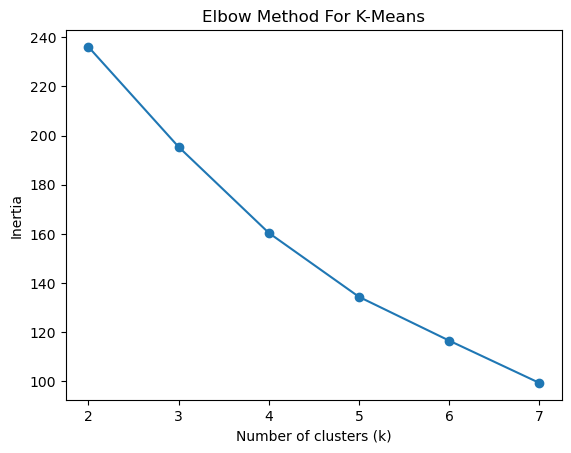

In [193]:
from sklearn.cluster import KMeans
# features for clustering
features = [
    "percent_uninsured",
    "percent_adults_with_disability",
    "health_disadvantage_score_AVG",
    "composite_score_AVG",
    "poverty_rate_avg",
    "disability_rate_mean_of_ratios_AVG"
]

# scale data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[features])

k_means_results = {}

inertias = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(x_scaled)
    inertias.append(kmeans.inertia_)
    k_means_results[k] = kmeans.labels_

# plot elbow curve this was so i could visually inspect the elbow point to find best k

plt.plot(list(K), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For K-Means')
plt.show()


In [200]:
# best k based on elbow method
best_k = 3

final_kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
df['kmeans_cluster'] = final_kmeans.fit_predict(x_scaled)

#cluster size 
print("\nCluster sizes:")
print(df['kmeans_cluster'].value_counts().sort_index())

#cluster means
print("\nCluster means:")
cluster_means = df.groupby('kmeans_cluster')[features].mean()
print(cluster_means)

anchor = "health_disadvantage_score_AVG"

C:\Users\alyss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster sizes:
kmeans_cluster
0    29
1    35
2    20
Name: count, dtype: int64

Cluster means:
                percent_uninsured  percent_adults_with_disability  \
kmeans_cluster                                                      
0                        7.316358                       13.856987   
1                        3.095286                        9.431927   
2                        5.740085                       13.699390   

                health_disadvantage_score_AVG  composite_score_AVG  \
kmeans_cluster                                                       
0                                    0.680782             0.765814   
1                                    0.350793             0.297539   
2                                    0.563341             0.539910   

                poverty_rate_avg  disability_rate_mean_of_ratios_AVG  
kmeans_cluster                                                        
0                       0.274310                            0.13

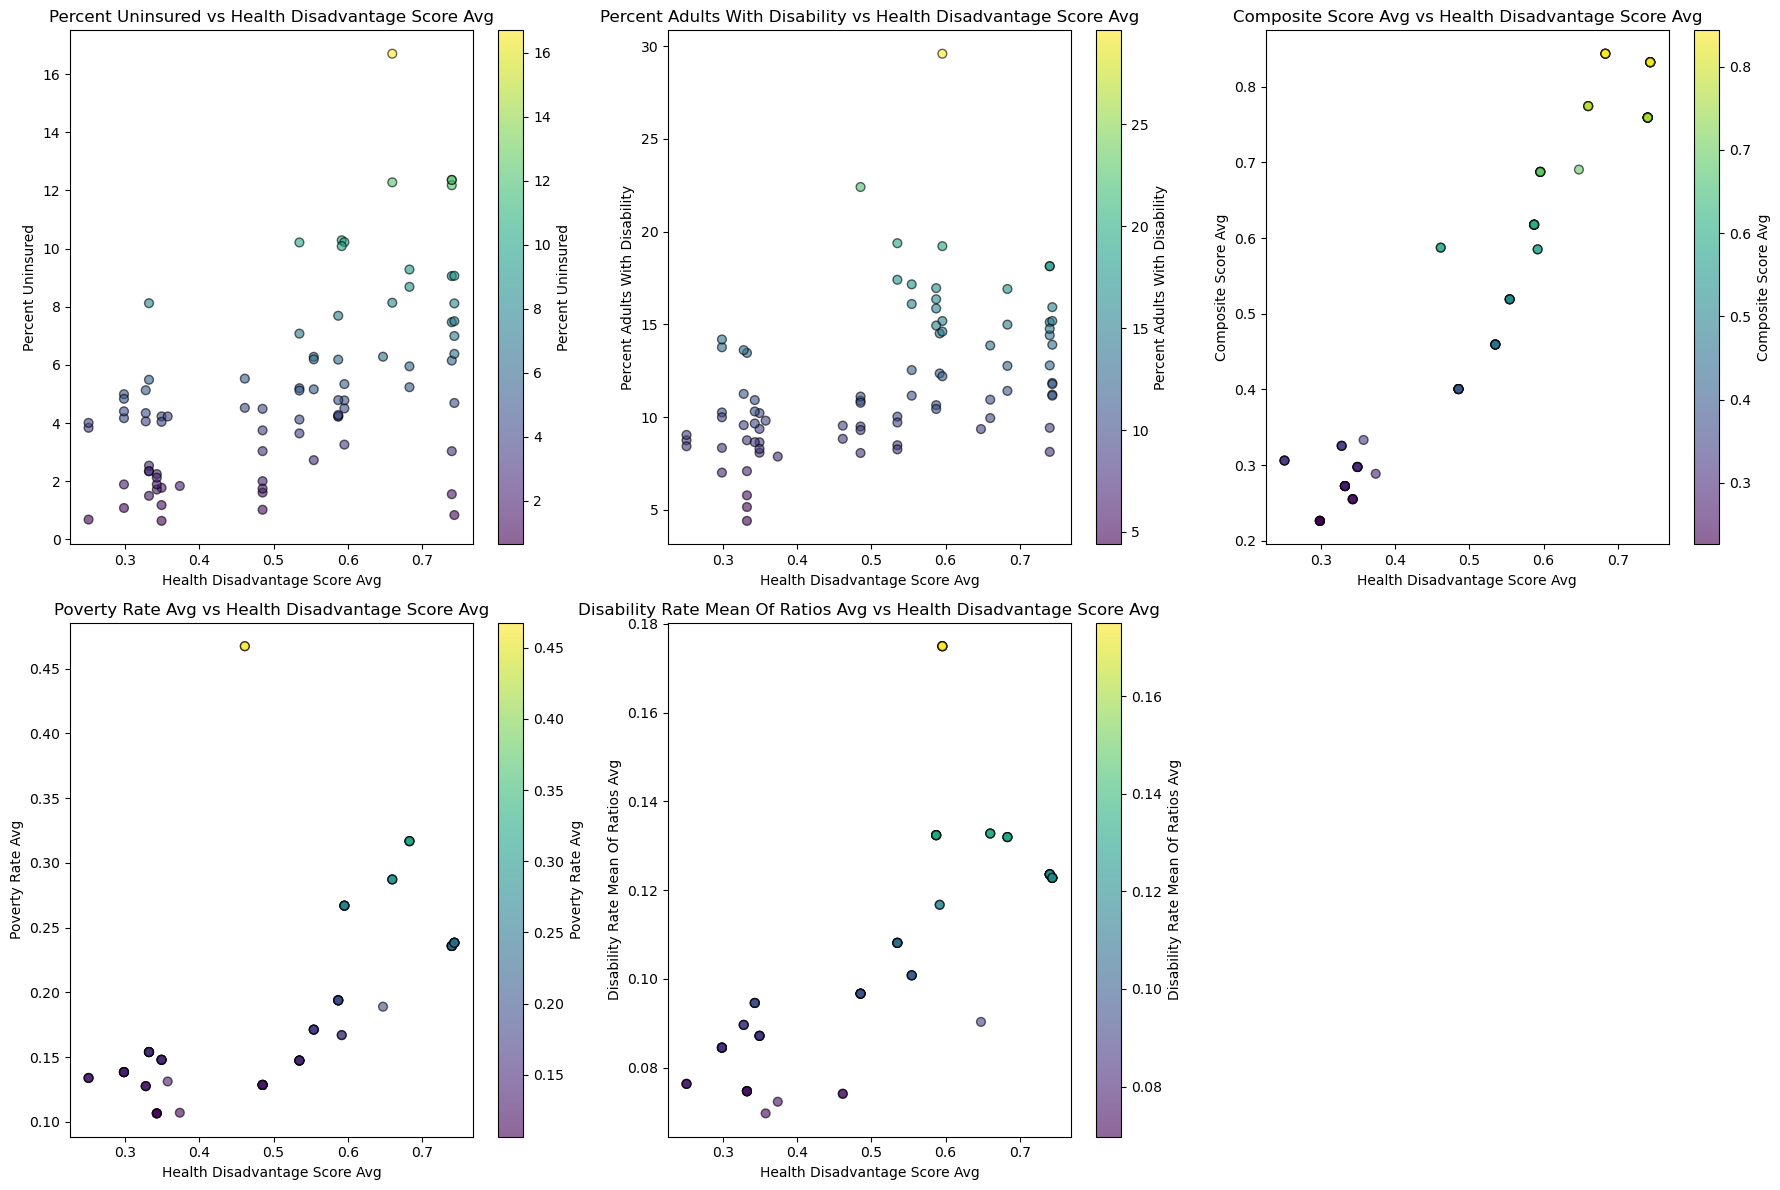


Clustered data saved to 'kmeans_clustered_data.csv'


In [202]:
#all other features but anchor
other_features = [col for col in features if col != anchor]

#2 rows and 3 column grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(other_features):
    ax = axes[i]
    scatter = ax.scatter(df[anchor], df[col], c=df[col], s=40, alpha=0.6, edgecolors='k')
    ax.set_xlabel(anchor.replace("_", " ").title())
    ax.set_ylabel(col.replace("_", " ").title())
    ax.set_title(f'{col.replace("_", " ").title()} vs {anchor.replace("_", " ").title()}')
    fig.colorbar(scatter, ax=ax, label=f'{col.replace("_", " ").title()}')

# Remove unused subplots            
for j in range(len(other_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Save the clustered data to a new CSV file
df.to_csv('kmeans_clustered_data.csv', index=False)
print("\nClustered data saved to 'kmeans_clustered_data.csv'")

## K-Means Summary
To explore the patterns of social and health disadvantage across Seattle neighborhoods, we applied K-Means clustering to six standardized indicators: percent uninsured, percent adults with disability, average health disadvantage score, composite disadvantage score, average poverty rate, and disability rate mean of ratios. Based on the elbow method, k = 3 was selected as the best number of clusters. This value balanced model simplicity with clear separation between clusters, as inertia declined sharply up to three clusters and then leveled off. The three clusters highlight distinct groupings of disadvantage. Cluster 1 includes neighborhoods with generally low poverty, disability, and health disadvantage scores, representing comparatively advantaged areas. Cluster 2 shows moderate levels across all metrics, suggesting mixed socioeconomic and health conditions. Cluster 3 contains the highest rates of uninsured adults, disability, and poverty, as well as the highest composite disadvantage and health disadvantage scores, indicating neighborhoods facing multiple overlapping barriers to well-being.
